In [ ]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout #Import some useful libraries

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


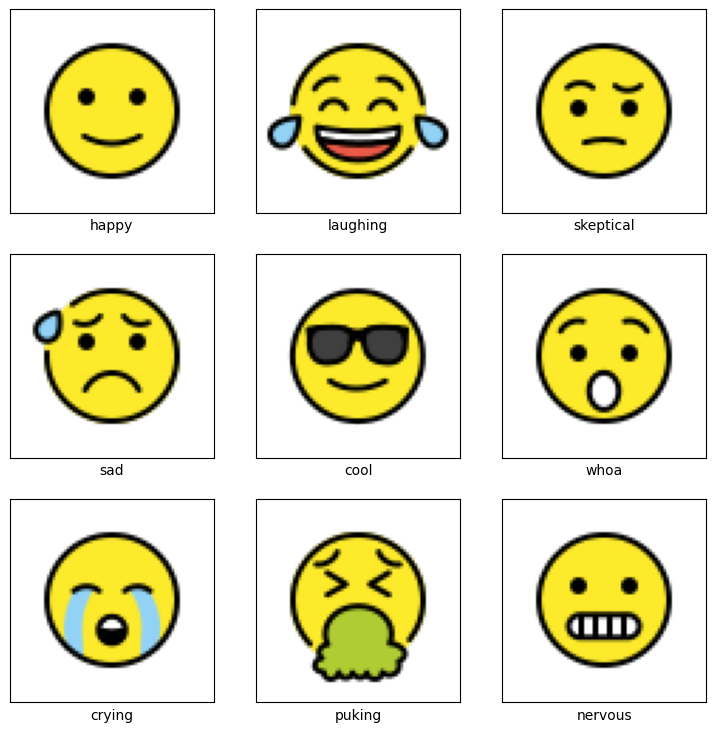

In [3]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'} 
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)                                  
    plt.imshow(plt.imread(os.path.join('emojis', e['file']))) 
    plt.xlabel(e['name'])                                     
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
for class_id, values in emojis.items():                                            
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')  
    png_file.load()                                                               
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))                   
    new_file.paste(png_file, mask=png_file.split()[3])                           
    emojis[class_id]['image'] = new_file                                        

In [5]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

In [ ]:
def create_example():
  class_id = np.random.randint(0, 9)                                          
  image = np.ones((144, 144, 3)) * 255                                        
  row = np.random.randint(0, 72)                                              
  col = np.random.randint(0, 72)                                              
  image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
  return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144  
                                                                              

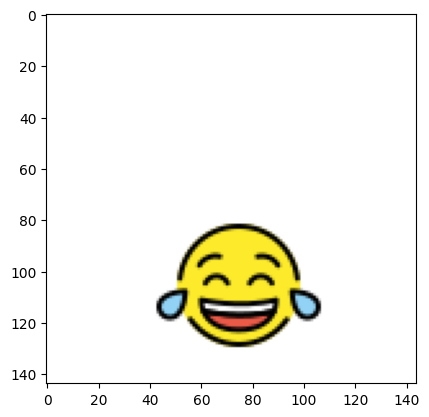

In [7]:
image, class_id, row, col = create_example()
plt.imshow(image);

In [ ]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):       
  if norm:                                                                
    image *= 255.                                                            
    image = image.astype('uint8')                                           
  image = Image.fromarray(image)                                           
  draw = ImageDraw.Draw(image)                                            

  row, col = gt_coords
  row *= 144                                                              
  col *= 144
  draw.rectangle((col, row, col + 52, row + 52), outline='green', width=3) 

  if len(pred_coords) == 2:                                                
    row, col = pred_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col + 52, row + 52), outline='red', width=3) 
  return image

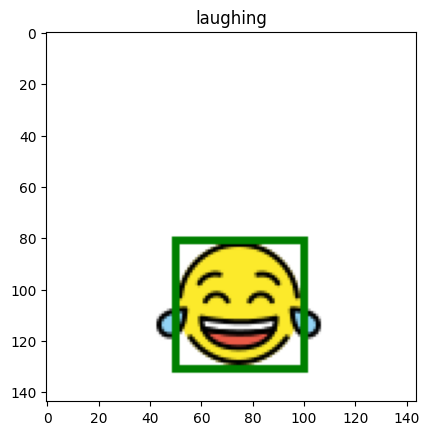

In [9]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

In [10]:
def data_generator(batch_size=16):                                         
  while True:
    x_batch = np.zeros((batch_size, 144, 144, 3))                          
    y_batch = np.zeros((batch_size, 9))                                    
    bbox_batch = np.zeros((batch_size, 2))                                 

    for i in range(0, batch_size):
      image, class_id, row, col = create_example()                         
      x_batch[i] = image / 255.                                           
      y_batch[i, class_id] = 1.0                                           
      bbox_batch[i] = np.array([row, col])                                 
    yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

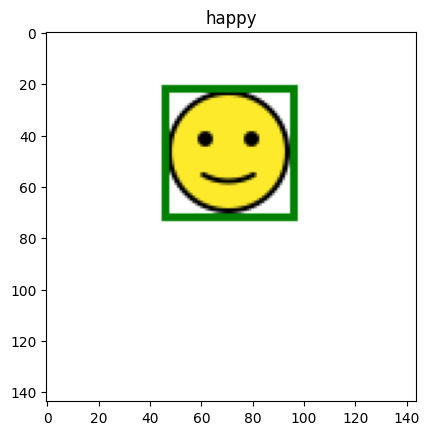

In [11]:
example, label = next(data_generator(1))           
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

In [12]:
input_ = Input(shape=(144, 144, 3), name='image')            

x = input_

for i in range(0, 5):
  n_filters = 2**(4 + i)                                       
  x = Conv2D(n_filters, 3, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)                          

model = tf.keras.models.Model(input_, [class_out, box_out])  
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 144, 144,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 142, 142,  │        448 │ image[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 142, 142,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 71, 71,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 69, 69,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 69,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 34, 34,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 5, 5, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 2, 2, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 659,819 (2.52 MB)

 Trainable params: 658,827 (2.51 MB)

 Non-trainable params: 992 (3.88 KB)

In [ ]:
class IoU(tf.keras.metrics.Metric):                                        
  def __init__(self, **kwargs):
    super(IoU, self).__init__(**kwargs)                                   
    
    self.iou = self.add_weight(name='iou', initializer='zeros')            
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
  
  def update_state(self, y_true, y_pred, sample_weight=None):
    def get_box(y):                                                        
      rows, cols = y[:, 0], y[:, 1]
      rows, cols = rows * 144, cols * 144
      y1, y2 = rows, rows + 52
      x1, x2 = cols, cols + 52
      return x1, y1, x2, y2
    
    def get_area(x1, y1, x2, y2):                                          
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
    
    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)                           
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)                              

    i_x1 = tf.maximum(gt_x1, p_x1)                                         
    i_y1 = tf.maximum(gt_y1, p_y1)                                         
    i_x2 = tf.minimum(gt_x2, p_x2)                                         
    i_y2 = tf.minimum(gt_y2, p_y2)                                         
    
    i_area = get_area(i_x1, i_y1, i_x2, i_y2)                             
    u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area 

    iou = tf.math.divide(i_area, u_area)                                  
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))                        
    self.iou = tf.math.divide(self.total_iou, self.num_ex)                
  
  def result(self):
    return self.iou                                                       
  
  def reset_state(self):                                                  
    self.iou = self.add_weight(name='iou', initializer='zeros')            
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

In [38]:
model.compile(
    optimizer='adam',
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    metrics={
        'class_out': ['accuracy'],
        'box_out': []
    }
)


In [15]:
def test_model(model, test_datagen):    
  example, label = next(test_datagen)
  x = example['image']
  y = label['class_out']
  box = label['box_out']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  gt_coords = box[0]
  pred_class = np.argmax(pred_y[0])    
  image = x[0]

  gt = emojis[np.argmax(y[0])]['name']           
  pred_class_name = emojis[pred_class]['name']

  image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
  color = 'green' if gt == pred_class_name else 'red'

  plt.imshow(image)
  plt.xlabel(f'Pred: {pred_class_name}', color=color)
  plt.ylabel(f'GT: {gt}', color=color)
  plt.xticks([])
  plt.yticks([])

In [16]:
def test(model):                   
  test_datagen = data_generator(1)

  plt.figure(figsize=(16, 4))

  for i in range(0, 6):
    plt.subplot(1, 6, i + 1)
    test_model(model, test_datagen)
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


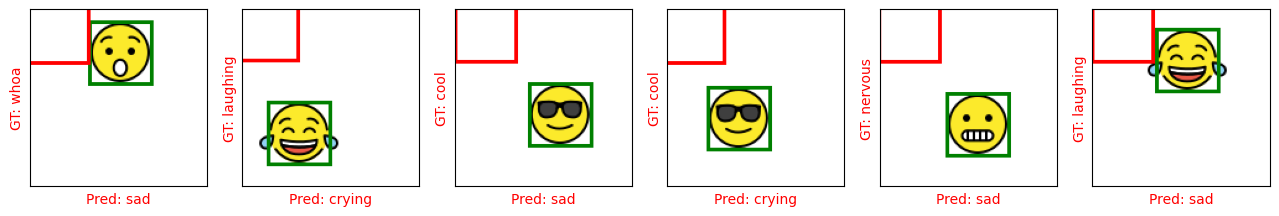

In [17]:
test(model)

In [ ]:
class ShowTestImages(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

In [26]:
print(model.metrics_names)

['loss', 'compile_metrics', 'class_out_loss', 'box_out_loss']


In [37]:
sample = next(data_generator())
print("Tipo de salida:", type(sample))
print("Contenido:", sample)


Tipo de salida: <class 'tuple'>
Contenido: ({'image': array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


      

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/stepstep - box_out_loss: 0.9087 - class_out_accuracy: 0.4435 - class_out_loss: 1.5769 - loss: 2.485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


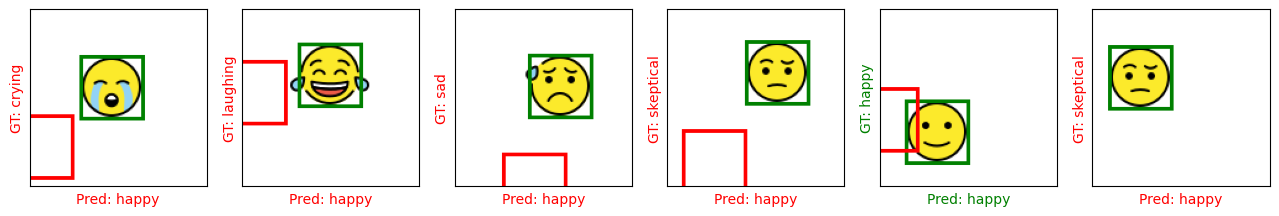

500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - box_out_loss: 0.9073 - class_out_accuracy: 0.4441 - class_out_loss: 1.5753 - loss: 2.4827 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepstep - box_out_loss: 0.0381 - class_out_accuracy: 0.9985 - class_out_loss: 0.0191 - loss: 0.057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


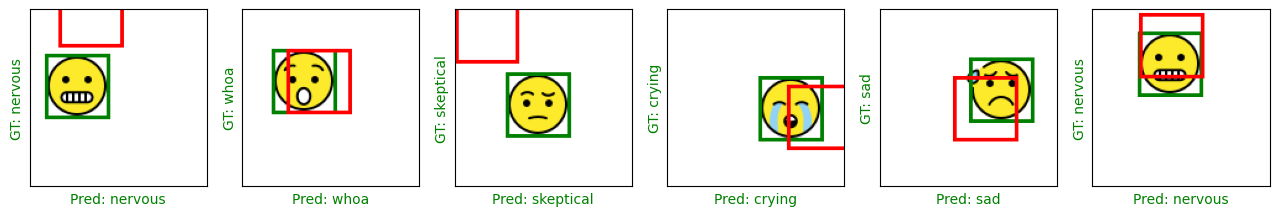

500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - box_out_loss: 0.0381 - class_out_accuracy: 0.9985 - class_out_loss: 0.0191 - loss: 0.0572 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepstep - box_out_loss: 0.0174 - class_out_accuracy: 0.9971 - class_out_loss: 0.0144 - loss: 0.031
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


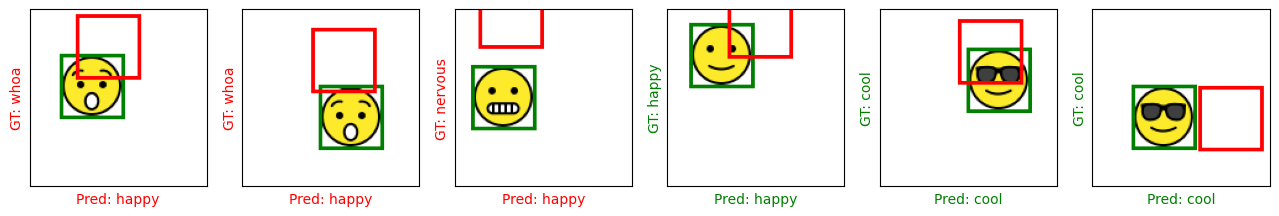

500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - box_out_loss: 0.0174 - class_out_accuracy: 0.9971 - class_out_loss: 0.0144 - loss: 0.0318 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/stepstep - box_out_loss: 0.0095 - class_out_accuracy: 1.0000 - class_out_loss: 0.0018 - loss: 0.011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


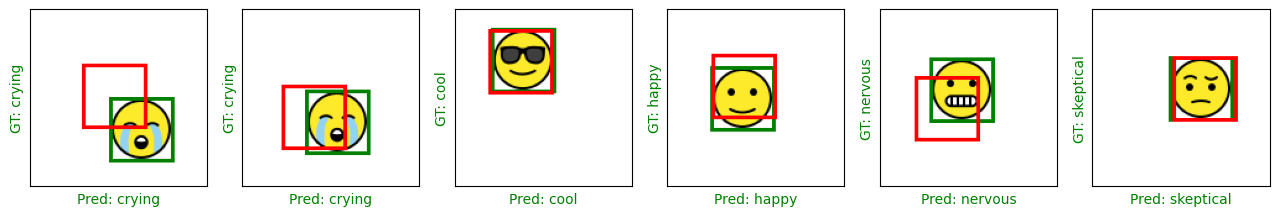

500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - box_out_loss: 0.0095 - class_out_accuracy: 1.0000 - class_out_loss: 0.0018 - loss: 0.0114 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/stepstep - box_out_loss: 0.0032 - class_out_accuracy: 1.0000 - class_out_loss: 8.6518e-04 - loss: 0.004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


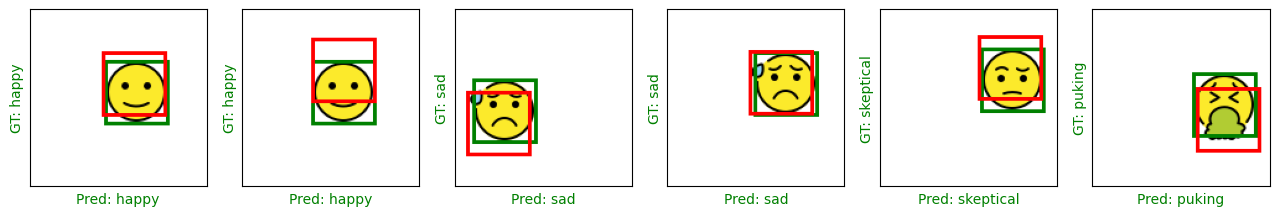

500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - box_out_loss: 0.0032 - class_out_accuracy: 1.0000 - class_out_loss: 8.6494e-04 - loss: 0.0040 - learning_rate: 2.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/stepstep - box_out_loss: 0.0022 - class_out_accuracy: 1.0000 - class_out_loss: 7.5267e-04 - loss: 0.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


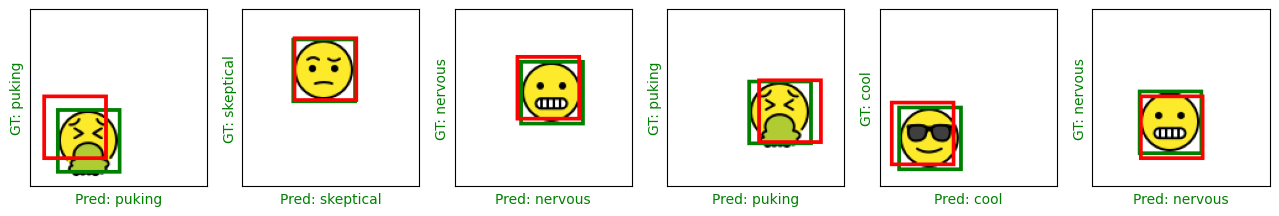

500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - box_out_loss: 0.0022 - class_out_accuracy: 1.0000 - class_out_loss: 7.5263e-04 - loss: 0.0030 - learning_rate: 2.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/stepstep - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - class_out_loss: 6.0734e-04 - loss: 0.002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


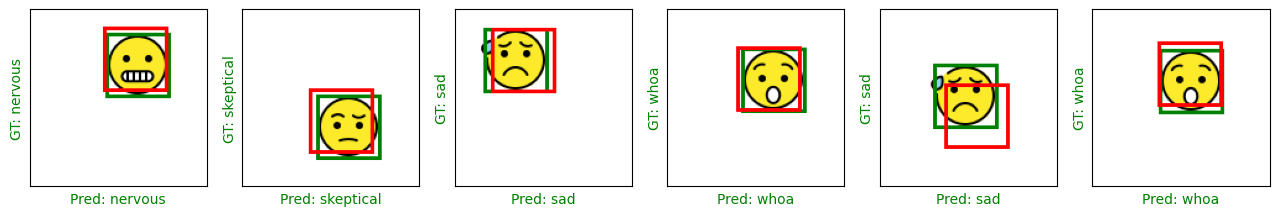

500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - class_out_loss: 6.0730e-04 - loss: 0.0027 - learning_rate: 2.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepstep - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - class_out_loss: 5.8535e-04 - loss: 0.002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


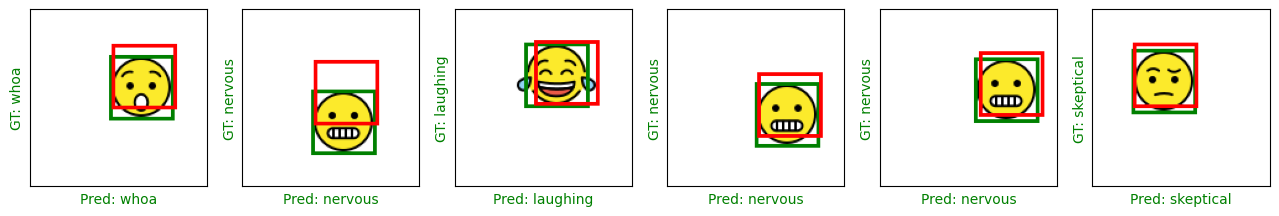

500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - class_out_loss: 5.8514e-04 - loss: 0.0025 - learning_rate: 2.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/stepstep - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - class_out_loss: 6.1910e-04 - loss: 0.002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


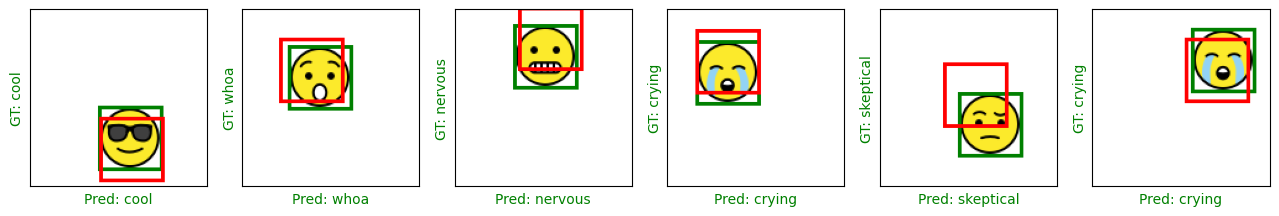

500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - class_out_loss: 6.1882e-04 - loss: 0.0025 - learning_rate: 2.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/stepstep - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - class_out_loss: 4.2914e-04 - loss: 0.001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


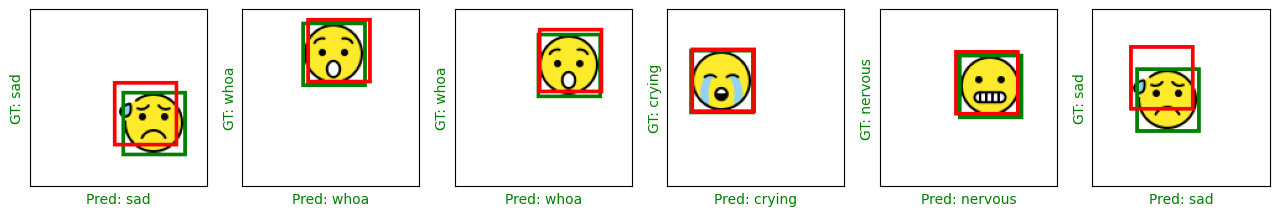

500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - class_out_loss: 4.2928e-04 - loss: 0.0018 - learning_rate: 4.0000e-05
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/stepstep - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - class_out_loss: 2.9146e-04 - loss: 0.001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


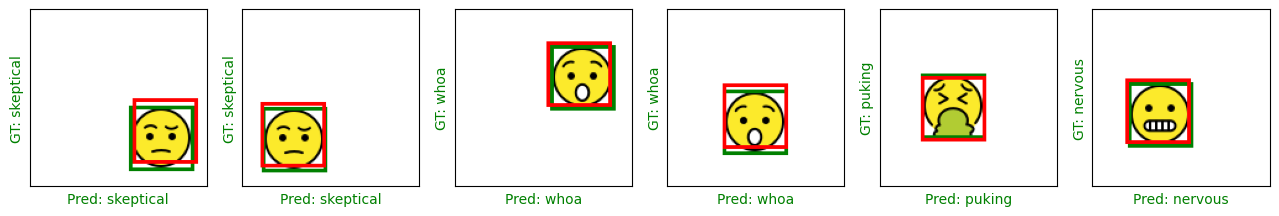

500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - class_out_loss: 2.9147e-04 - loss: 0.0015 - learning_rate: 4.0000e-05
Epoch 12/50
270/500 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - class_out_loss: 3.0331e-04 - loss: 0.0015

KeyboardInterrupt: 

In [ ]:
def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2              
  return max(lr, 3e-7)    

_ = model.fit(
    data_generator(batch_size=16),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_loss', patience=3, mode='min'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)